In [1]:
#Lets import the necessary packages
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
import matplotlib.pyplot as plt
#define todays datetime
now = datetime.datetime.now()
from dateutil.relativedelta import relativedelta
#uncomment below to override tiingo_key with your own! 
tiingo_key = 'c45f59abd1f342047df4025a5412c16d3ed11c45'

#Settings
new_money_in = 0
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 30 #in days

#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

In [2]:
#get first tuesday of a given month and year
def get_day(year, month):
    d = datetime.datetime(year, month, 1)
    offset = 1-d.weekday() #weekday = 1 means tuesday
    if offset < 0:
        offset+=7
    return d+datetime.timedelta(offset)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

def get_prices(tickers, rebalance_date):
    bad_tickers = []
    for i, t in enumerate(tickers):
        try:
            if i==0:
                pricelist = pdr.get_data_tiingo(t, start, rebalance_date, api_key=tiingo_key).tail(1).close
            else:
                pricelist = pricelist.append(pdr.get_data_tiingo(t, start, rebalance_date, api_key=tiingo_key).tail(1).close)
        except:
            bad_tickers.append(t)

    print(bad_tickers)
    #Manual fix for known bad_tickers which Tiingo can't find, adjust to suit your needs
    if 'VMFXX' in bad_tickers:
        pricelist2.loc['VMFXX'] = 1.0
        
    pricelist = pricelist.to_frame(name='close')
    pricelist.rename(columns={"close":"price"},  inplace=True)

    #drop our date index since its only the latest data
    pricelist2=pricelist.reset_index(level=1, drop=True)
    pricelist2.loc['MONEY']=1.0
    return pricelist2

In [3]:

#initialize target portfolio
#targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
targetalloc = pd.read_csv('../assets/targetmodel.csv')
total=decimal.Decimal(targetalloc.allocation_target.sum())
#check that our target allocation indeed adds to 100%
assert round(total,4) == 1,'Target Allocation not 100% : {}'.format(int(total))

#initialize current portfolio
#port_taxlots = pd.DataFrame(columns = columns_c, data = taxlots_c)
port_taxlots = pd.read_csv('../assets/taxlots.csv')
port_taxlots.lastrebaldate = pd.to_datetime(port_taxlots.lastrebaldate)
port_taxlots.basisdate = pd.to_datetime(port_taxlots.basisdate)

#aggregate by ticker to account for securities held to compute positions
port_positions = port_taxlots.groupby(['ticker']).apply(f)

In [4]:
#pick a day for rebalancing
start = datetime.datetime.strptime('2015-01-02', '%Y-%m-%d').date()
current_date = start + relativedelta(months=+3)
rebalance_date = get_day(current_date.year,current_date.month)

In [5]:
#Collect list of distinct tickers we care about
tickerlist = set(targetalloc.ticker.unique().tolist()+port_taxlots.ticker.unique().tolist())

# get prices of distinct tickers
prices = get_prices(tickerlist, start)


['MONEY']


In [6]:
#combine current and target portfolio
start_port_c = pd.merge(port_positions, targetalloc, on ='ticker', how ='outer')
# add current prices
final_port = pd.merge(start_port_c, prices, left_on ='ticker', right_index = True, how = 'left')
#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.price,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#calculate holding values and current allocation
final_port['value'] = final_port.price * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in
#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(rebalance_date.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag_exit'] = np.where((final_port.allocation > 0) & (final_port.allocation_target==0),1,0) #force rebal securities not present in our target portfolio
final_port['rebal_flag_newmoney'] = np.where(final_port.new_money_in>0,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time + final_port.rebal_flag_exit + final_port.rebal_flag_newmoney >= 1,1,0)

#Subset of securities we need to rebalance, and those we need to leave alone
rebal_port = final_port[final_port.rebal_flag==1].copy()
stable_port = final_port[final_port.rebal_flag==0].copy()

In [7]:
#Calculate our current allocation, target, and the change we need to hit target
total_val = rebal_port.value.sum()
rebal_port['allocation'] = rebal_port.value/rebal_port.value.sum()
rebal_port['allocation_target'] = rebal_port.allocation_target/rebal_port.allocation_target.sum()
rebal_port['correction'] = rebal_port.allocation_target - rebal_port.allocation

#Factor in any new money entering the portfolio and determine necessary changes in value and shares
rebal_port['value_chg'] = (total_val * rebal_port.correction) + rebal_port.new_money_in
rebal_port['shares_chg'] = rebal_port.value_chg / rebal_port.price
rebal_port.loc[rebal_port.value_chg.isna() & rebal_port.shares > 0,['shares_chg']]=-rebal_port.shares #sell all shares of securities not in our target portfolio

#Round off shares to whole numbers, except when we are fully exiting a position
rebal_port['shares_chg_round'] = rebal_port.shares_chg
rebal_port = rebal_port.astype({'shares_chg_round': int})
rebal_port['final_shares_chg'] = rebal_port.shares_chg
rebal_port.loc[np.round(rebal_port.shares_chg+rebal_port.shares)!=0,['final_shares_chg']]=rebal_port.shares_chg_round*1.0
rebal_port.drop(['shares_chg_round'],axis=1,inplace=True)

#Calculate initial new shares and values
rebal_port['new_shares'] = np.round(rebal_port.shares + rebal_port.final_shares_chg,3)
rebal_port['new_value'] = rebal_port.new_shares * rebal_port.price #due to share rounding, there will be slight variance vs. portfolio starting value
rebal_port['new_value_chg'] = rebal_port.final_shares_chg * rebal_port.price

In [8]:
#Double check our work so far
#net of buying and selling should be zero
assert(np.round(rebal_port.value_chg.sum(),3)-new_money_in==0) 
#make sure totals match (with rounding error + new money in) from original portfolio and rebalanced portfolio
assert(np.round(rebal_port.new_value.sum() - rebal_port.value.sum(),3)==np.round((rebal_port.new_value.sum() + stable_port.value.sum()) - final_port.value.sum(),3))

In [9]:
#Merge our rebalanced portfolio with our stable portfolio for our execution portfolio
stable_port['value_chg'] = 0
stable_port['shares_chg']=0
stable_port['final_shares_chg'] = 0
stable_port['new_value_chg'] = 0
stable_port['new_shares'] = stable_port.shares
stable_port['new_value'] = stable_port.value
exec_port = pd.concat([rebal_port,stable_port],sort=False)
exec_port.drop(columns=['timedelta','rebal_flag_thresh','rebal_flag_time','rebal_flag_exit','rebal_flag_newmoney','value_chg','shares_chg'],inplace=True)

#Reset allocations to be based on all securities
exec_port['allocation'] = exec_port.value/exec_port.value.sum()
exec_port['allocation_target'] = exec_port.allocation_target/exec_port.allocation_target.sum()
exec_port['correction'] = exec_port.allocation_target - exec_port.allocation
exec_port['final_allocation'] = exec_port.new_value / exec_port.new_value.sum()

print(exec_port)

  ticker lastrebaldate assetclass  basisdate  costbasis    shares  \
0  MONEY    2013-01-01         ST 2013-01-01       1.00  100000.0   
1   AAPL           NaT         ST 2022-02-26     109.33       0.0   
2    PFE           NaT         ST 2022-02-26      31.33       0.0   
3     HD           NaT         ST 2022-02-26     103.43       0.0   
4    DVN           NaT         ST 2022-02-26      60.96       0.0   

   allocation_target   price     value  allocation  correction  new_money_in  \
0               0.00    1.00  100000.0         1.0       -1.00           0.0   
1               0.25  109.33       0.0         0.0        0.25           0.0   
2               0.25   31.33       0.0         0.0        0.25           0.0   
3               0.25  103.43       0.0         0.0        0.25           0.0   
4               0.25   60.96       0.0         0.0        0.25           0.0   

   rebal_flag  final_shares_chg  new_shares  new_value  new_value_chg  \
0           1         -100000.0

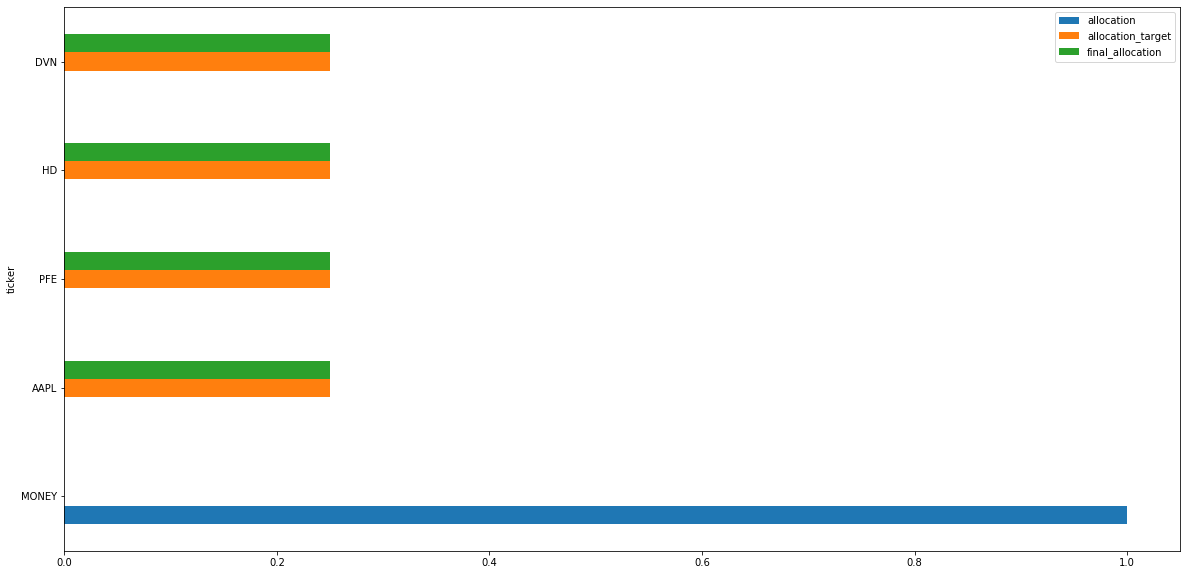

In [10]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))
plt.show()

In [11]:
port_taxlots

,accounttype,accountid,lastrebaldate,ticker,assetclass,basisdate,costbasis,shares
0,TAXB,3333,2013-01-01,MONEY,ST,2013-01-01,1,100000
